## Preliminary Modelling
Start with simple (single-output) modelling methods

In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import datasets, linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the data
df_all = pd.read_csv('220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

In [4]:
# Create some new features
df_inp['densDiff'] = df_inp['slugDen'] - df_inp['pockDen']
df_inp['centrFor'] = df_inp['slugVel']**2 * df_inp['densDiff']

In [5]:
df_inp.describe()

,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_oopDisp_mm_n5,out_endBend_kNm_n6,densDiff,centrFor
count,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000
mean,749.873015,10.000500,199.759649,10.010242,7.993685,11.999793,0.699832,60.026618,41.568940,182.077874,187.301203,218.388931,550.113366,37334.067936
std,75.247244,1.988917,49.987285,1.998691,1.990544,1.001185,0.100230,10.025549,15.654733,31.026056,44.422666,59.079226,90.197457,19028.582742
min,439.010000,0.750000,9.470000,2.070000,0.400000,8.050000,0.270000,20.910000,15.200000,73.240000,73.890000,83.330000,182.810000,69.683200
25%,699.075000,8.660000,166.205000,8.650000,6.655000,11.330000,0.630000,53.210000,32.600000,162.600000,160.960000,177.360000,488.995000,23384.349586
50%,749.200000,10.010000,199.700000,10.010000,7.990000,12.000000,0.700000,59.980000,38.500000,179.730000,180.340000,209.190000,549.770000,34583.397120
75%,801.125000,11.340000,233.475000,11.370000,9.330000,12.680000,0.770000,66.825000,46.700000,198.140000,203.755000,247.500000,610.910000,48175.250965
max,1066.900000,18.220000,404.010000,17.860000,16.810000,16.380000,1.110000,106.850000,884.800000,497.920000,711.910000,700.150000,951.300000,169747.298550


In [6]:
df_inp.head(3)

,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_oopDisp_mm_n5,out_endBend_kNm_n6,densDiff,centrFor
0,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8,197.45,180.47,198.49,551.51,18361.367279
1,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0,186.85,178.72,238.07,514.59,28331.472876
2,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2,155.47,163.53,180.64,582.89,32091.824996


## Data Scaling & Splitting

In [7]:
df_scl = df_inp.copy(deep=True)
scaler = preprocessing.StandardScaler() # Scale using standard deviation
df_scl = pd.DataFrame(scaler.fit_transform(df_scl), columns = df_scl.columns, index = df_scl.index)

In [14]:
# Create percentile field for sratification
df_scl['splits'] = pd.qcut(df_scl['out_oopDisp_mm_n2'], 100, labels=False)

In [37]:
# Create train and test splits (20% test)
train, test = train_test_split(df_scl, test_size=0.20, stratify=df_scl['splits'], random_state=0) 

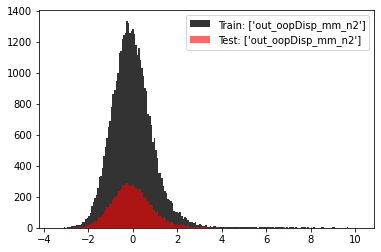

Max (train) =  10.2
Max (test) =  8.5


In [38]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(test[param].values, bins=n_bins, label = f'Test: {param}', color = 'red', alpha=0.6, zorder=2)
axs.legend(loc = 'upper right')
plt.show()
print('Max (train) = ', round(train[param].values.max(), 1))
print('Max (test) = ', round(test[param].values.max(), 1))

In [39]:
# Drop the splits column
train = train.drop(['splits'], axis=1)
test = test.drop(['splits'], axis=1)

In [40]:
pred_target = ['out_oopDisp_mm_n2']
pred_features = [
    'slugDen',  # 0
    'slugLen',  # 1
    'pockDen',  # 2
    'pockLen',  # 3
    'slugVel',  # 4
    'basePer',  # 5
    'baseAmp',  # 6
    'basePha',  # 7
    'simTime',  # 8
    'densDiff', # 9
    'centrFor'  # 10
]
pred_features = pred_features[:]
X_train = train.filter(pred_features)
y_train = train.filter(pred_target)
X_test = test.filter(pred_features)
y_test = test.filter(pred_target)

In [41]:
X_train.head(3)

,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,densDiff,centrFor
23066,1.173437,0.628237,-0.123426,0.260052,0.018244,0.349796,1.298706,1.896512,-0.036343,1.047342,0.222248
4160,-0.028347,-0.643824,0.503340,2.021222,-1.212588,0.179995,-0.996038,-0.075470,1.222075,-0.302599,-1.106522
3893,0.652881,-0.508071,0.516544,0.230032,0.093601,-1.128467,1.099163,0.918002,-0.298248,0.258398,0.054384


## 1) Linear Regression

In [64]:
# create linear regression object
reg = linear_model.LinearRegression()
# train the model using the training sets
reg.fit(X_train, y_train)

LinearRegression()

In [65]:
# Regression coefficients
print('Coefficients: ', reg.coef_)
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [[-4.44212320e+11 -1.08947754e-01  2.95093437e+11 -9.84884093e-02
  -5.70813501e-02 -2.56494028e-03  6.88661348e-01 -6.54437831e-03
   2.66661852e-02  5.32468960e+11  4.63544550e-01]]
Variance score: 0.6597293685587109


In [66]:
# Scaling for inverse transform
y_bas = df_inp['out_oopDisp_mm_n2'].to_numpy().reshape(-1, 1)
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)
y_rsl = scaler_m.inverse_transform(y_scl)

In [67]:
y_bas

array([[197.45],
       [186.85],
       [155.47],
       ...,
       [168.38],
       [169.73],
       [178.7 ]])

In [68]:
y_rsl

array([[197.45],
       [186.85],
       [155.47],
       ...,
       [168.38],
       [169.73],
       [178.7 ]])

In [69]:
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(reg.predict(X_test))

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R-Squared:", round(r2, 2))

Results of sklearn.metrics:
MAE: 11.17
MSE: 320.38
RMSE: 17.9
R-Squared: 0.66


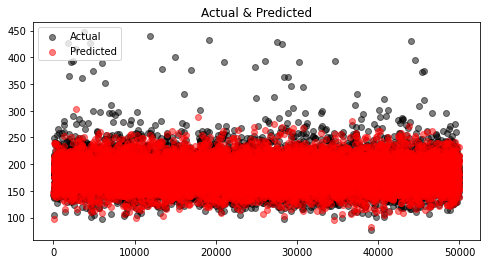

In [70]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.scatter(X_test.index, y, label = "Actual", color = 'black', zorder = 1, alpha=0.5)
plt.scatter(X_test.index, yhat, label = "Predicted", color = 'red', zorder = 2, alpha=0.5)
plt.legend(loc = "upper left")
plt.title("Actual & Predicted")
plt.show()

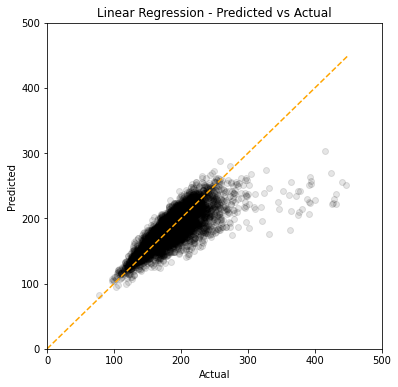

In [71]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(y, yhat, color = 'black', zorder = 1, alpha=0.1)
plt.plot([0, 450], [0, 450], '--', color = 'orange', zorder = 2)
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("Linear Regression - Predicted vs Actual")
plt.show()

## 2) Random Forest Regression
The main benefit of using regression trees is that these methods are able to find non-linear relationships between the dependent and independent variables whereas the previous method focused on the linear relationships. This is often of benefit when it comes to more complex relationships between variables but can sometimes come at the cost of overfitting and also time and resources.

In [72]:
# Fitting Random Forest Regression to the Training set
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)    
regressor.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

RandomForestRegressor(n_estimators=50, random_state=0)

In [73]:
y_pred = regressor.predict(X_test.to_numpy())

In [74]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred.reshape(-1, 1))

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R-Squared:", round(r2, 2))

Results of sklearn.metrics:
MAE: 5.69
MSE: 76.16
RMSE: 8.73
R-Squared: 0.92


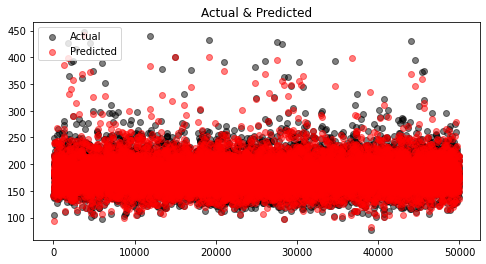

In [75]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.scatter(X_test.index, y, label = "Actual", color = 'black', zorder = 1, alpha=0.5)
plt.scatter(X_test.index, yhat, label = "Predicted", color = 'red', zorder = 2, alpha=0.5)
plt.legend(loc = "upper left")
plt.title("Actual & Predicted")
plt.show()

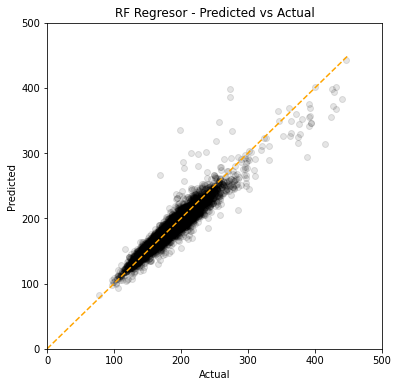

In [76]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(y, yhat, color = 'black', zorder = 1, alpha=0.1)
plt.plot([0, 450], [0, 450], '--', color = 'orange', zorder = 2)
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("RF Regresor - Predicted vs Actual")
plt.show()

In [77]:
df_imp = pd.DataFrame()
df_imp["Para"], df_imp["importance"] = [list(X_test.columns), regressor.feature_importances_]
df_imp.sort_values('importance', ascending=False)

,Para,importance
6,baseAmp,0.472220
8,simTime,0.343280
1,slugLen,0.040683
3,pockLen,0.035197
4,slugVel,0.033431
10,centrFor,0.020930
9,densDiff,0.019516
0,slugDen,0.011959
5,basePer,0.008238
7,basePha,0.007411


## 3) Mulit-layer Perceptron (MLP) - Simple Feed-Forward Neural Network
Class MLPRegressor implements a multi-layer perceptron (MLP) that trains using backpropagation with no activation function in the output layer, which can also be seen as using the identity function as activation function. Therefore, it uses the square error as the loss function, and the output is a set of continuous values.
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [78]:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [ ]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy().ravel())
y_pred = clf.predict(X_test.to_numpy())

In [ ]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred.reshape(-1, 1))

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R-Squared:", round(r2, 2))

In [ ]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.scatter(X_test.index, y, label = "Actual", color = 'black', zorder = 1, alpha=0.5)
plt.scatter(X_test.index, yhat, label = "Predicted", color = 'red', zorder = 2, alpha=0.5)
plt.legend(loc = "upper left")
plt.title("Actual & Predicted")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(y, yhat, color = 'black', zorder = 1, alpha=0.1)
plt.plot([0, 450], [0, 450], '--', color = 'orange', zorder = 2)
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("MLP Regressor - Predicted vs Actual")
plt.show()